In [3]:
import numpy as np
from matplotlib import pyplot as plt

### Extending the 1RM calculator

Many are familiar with the idea of one rep max (1RM) calculators, where a weight and a number of reps performed is used to calculate the maximum weight the trainee could lift. Perhaps the most popular formula is the Epley formula:
$$1\mathrm{RM} = \mathrm{weight} \cdot \left( 1 + \frac{\mathrm{reps}}{30} \right)$$
In many cases, this is reasonably good. Few would call it perfect however. The main drawback is simply that the repetition strength varies between individuals and can be trained separately from increasing maximum strength. Thus, a more appropriate formula may be:
$$1\mathrm{RM} = \mathrm{weight} \cdot \left( 1 + \frac{\mathrm{reps} - 1}{\mathrm{repetition\:strength}} \right)$$
written more succinctly as
$$m = w \cdot \left( 1 + \frac{r - 1}{h} \right) .$$
To ensure a more well-behaved formula, the number of repetitions is switched for the number of repetitions minus one. This ensures that inputting a 1RM predicts the same number, rather than something slighly bigger. Letting $h = 29$ approximately reproduces the standard Epley formula, see below.

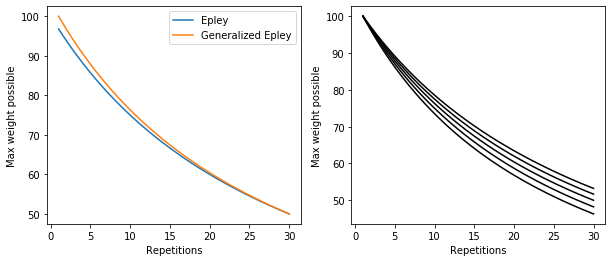

In [14]:
# if m = w*(1 + (r - 1)/h)
# then w = m/(1 + (r - 1)/h)
fig, axs = plt.subplots(ncols=2)
x = np.linspace(1, 30)
axs[0].plot(x, 100/(1 + x/30), label='Epley')
axs[0].plot(x, 100/(1 + (x - 1)/29), label='Generalized Epley')
for h in [25, 27, 29, 31, 33]:
    axs[1].plot(x, 100/(1 + (x - 1)/h), color='k')
axs[0].legend()
for i in range(2):
    axs[i].set_xlabel('Repetitions')
    axs[i].set_ylabel('Max weight possible')
fig.set_size_inches(10, 4)
plt.show()

However, we will let $h$ be a variable, which shifts the slope of the curve seen in the rightmost panel above.

### Incorporating history

If we assume that the above model is an accurate representation of how the 1RM, reps and weight interact, we can calculate the rep-strength-curve for a particular individual. It could then be used to plan training in the future, in much the same way that knowing the 1RM is used to plan training.

If we have some recent XRM results (so recent that we can assume $m$ or $h$ haven't changed between them), it is a simple curve fitting problem:

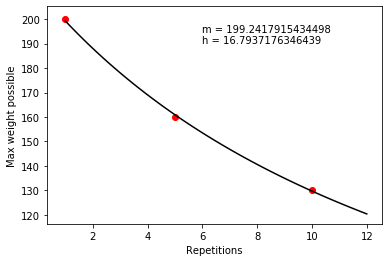

In [30]:
from scipy.optimize import minimize

# assume that we know a 1RM, 5RM and 10RM
R = np.array([1, 5, 10])
W = np.array([200, 160, 130])

def inverse_epley(m, w, h):
    # calculate the number of reps possible given by r = h*(m/w - 1) + 1
    return h*(m/w - 1) + 1

res = minimize(
    lambda x: np.sum( (inverse_epley(x[0], W, x[1]) - R)**2 ),
    (200, 29)
)

m, h = res.x

fig, axs = plt.subplots()
x = np.linspace(1, 12)
axs.plot(x, m/(1 + (x - 1)/h), color='k')
axs.scatter(R, W, color='r')
axs.text(6, 190, 'm = {}\nh = {}'.format(m, h))
axs.set_xlabel('Repetitions')
axs.set_ylabel('Max weight possible')
plt.show()

As we can see, fitting the curve in this case is rather simple. In practice however, both $m$ and $h$ change over time, and this needs to be accounted for. In the case of `amraplanner.py` this is done simply by weighting datapoints by their age, so that more recent data is taken more strongly into account. 

There is also another small optimization which somewhat improves the result. If a trainee manages 3 reps with a given weight, that may have been just scraping by (i.e. 3.0 reps) or just barely failing 4 (i.e. 3.99 reps) or anything in between. Thus adding 0.5 to the reps performed slightly improves the prediction by including this inaccuracy.

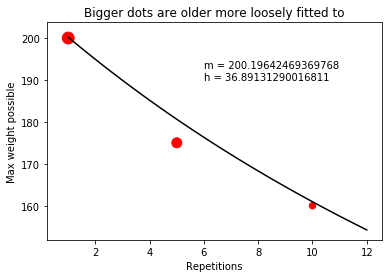

In [55]:
R = np.array([1, 5, 10])
W = np.array([200, 175, 160])
A = np.array([7, 5, 2])

res = minimize(
    lambda x: np.sum( (inverse_epley(x[0], W, x[1]) - R - 0.5)**2 / (A + 1) ),
    (200, 29)
)

m, h = res.x

fig, axs = plt.subplots()
x = np.linspace(1, 12)
axs.plot(x, m/(1 + (x - 1)/h), color='k')
axs.scatter(R, W, color='r', s=A*20)
axs.text(6, 190, 'm = {}\nh = {}'.format(m, h))
axs.set_xlabel('Repetitions')
axs.set_ylabel('Max weight possible')
axs.set_title('Bigger dots are older more loosely fitted to')
plt.show()

By calculating the age-weights from a certain date, we can also produce plots of how $m$ and $h$ change over time.

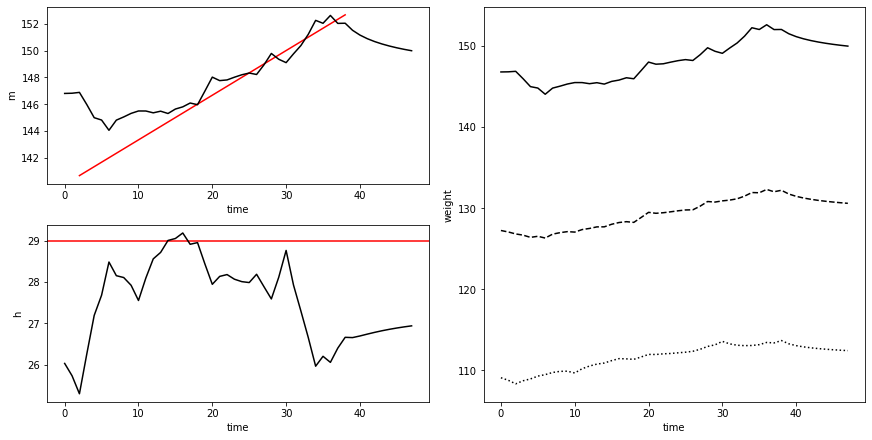

In [95]:
from matplotlib import gridspec as gridspec

# Generate data where the 1RM increases over time

def r25(x):
    # round to nearest 2.5
    return 2.5*np.round(x/2.5)

T = np.arange(1, 20)*2
M_real = T/3 + 140
W = r25( np.random.uniform(0.65, 1.0, T.size)*M_real )
R = np.floor( inverse_epley(M_real, W, 29) )

# Do the curve fit for each point in time

M = []
H = []
time_axis = np.arange(0, np.max(T) + 10)

for t in time_axis:
    A = np.abs(T - t)
    res = minimize(
        lambda x: np.sum( (inverse_epley(x[0], W, x[1]) - R - 0.5)**2 / (A + 1) ),
        (200, 29)
    )
    M.append(res.x[0])
    H.append(res.x[1])
    
M = np.array(M)
H = np.array(H)

fig = plt.figure(constrained_layout=True)
spc = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)
axs = np.array([
    fig.add_subplot(spc[0, 0]), 
    fig.add_subplot(spc[1, 0]), 
    fig.add_subplot(spc[:, 1])
])

axs[0].plot(T, M_real, color='r')
axs[0].plot(time_axis, M, color='k')
axs[1].axhline(29, color='r')
axs[1].plot(time_axis, H, color='k')
axs[2].plot(time_axis, M/(1 + (1 - 1)/H), color='k', linestyle='-', label='1RM')
axs[2].plot(time_axis, M/(1 + (5 - 1)/H), color='k', linestyle='--', label='5RM')
axs[2].plot(time_axis, M/(1 + (10 - 1)/H), color='k', linestyle=':', label='10RM')

axs[0].set_xlabel('time')
axs[0].set_ylabel('m')
axs[1].set_xlabel('time')
axs[1].set_ylabel('h')
axs[2].set_xlabel('time')
axs[2].set_ylabel('weight')

fig.set_size_inches(12, 6)
plt.show()

And that's it for the methodology behind `amraplanner.py`! The tracking isn't perfect; but some noise is expected. Using this tracking and some kind of randomization template, we can generate sensible training programs every week that will adapt to have a manageable weight for any individual trainee. See the example template `amrap.template` for how this is done.

#### Minor note on reps in reserve (RiR)
Adding reps in reserve is easy. Simply count an $x$ rep set with $y$ reps in reserve as an $x+y$ rep set to fail. The rest of the math is identical.

## Taking it further

The above methodology is simple and works decently, but there are improvements that can be made.
- As it relies on x-RM measurements, it requires doing heavy sets near failure fairly regularly to track progress.
- $h$ should weakly trend towards 29 (which is why the standard Epley formula works).
- No predictions about non-rested sets can be made.
- $m$ and $h$ should likely change more smoothly, and possibly have some measure of momentum in the sense that we would not expect the max to suddenly drop significantly for a trainee that's been making steady progress.

To adress all of these, we will introduce two changes. This will eventually lead to the model used in `rngfit.py`.

### Rest between sets
